In [2]:
from astropy.io import fits
import numpy as np
import pymysql
import morph
import os, sys, time
api_key = os.environ['TNG_API_KEY']
scratch_path = os.environ['MYSCRATCH']

In [3]:
universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum = 91 # 72 # 91 
subfindid = 391507 # 360895 # 391507 

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'
if not os.access(img_path,0): 
    os.system(f'mkdir -p {img_path}')

for camera in ['v0','v1','v2','v3']:

    out_name = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}.fits'
    if os.access(out_name,0):
        continue
    
    img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
    if not os.access(img_name,0):
        base_url = f'http://www.tng-project.org/api'
        img_url = f'{base_url}/{simulation}/snapshots/{snapnum}/subhalos/{subfindid}/skirt/skirt_images_hsc_realistic_{camera}.fits'
        sys_cmd = f'wget -nc -nv --content-disposition --header="API-Key:{api_key}" "{img_url}" -P {img_path}'
        os.system(sys_cmd)
    
    # Pass target image to R
    os.environ['IMG_NAME'] = img_name
    os.environ['UNIVERSE'] = universe
    os.environ['SIMULATION'] = simulation
    os.environ['SNAPNUM'] = str(snapnum)
    os.environ['SUBFINDID'] = str(subfindid)
    os.environ['CAMERA'] = camera
    os.environ['OUT_NAME'] = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}.fits'
    
    os.system('Rscript profit_sersic.r')

2024-08-29 13:40:52 URL:https://data-eu.tng-project.org/file/skirt_images_hsc_realistic_v1/L35n2160TNG/91/391507/?token=cff32712139a9226047c [57444480/57444480] -> "/scratch/pawsey0119/bottrell/Simulations/virgotng/data/IllustrisTNG/TNG50-1/postprocessing/skirt_images_hsc/realistic/091/shalo_091-391507_v1_HSC_GRIZY.fits" [1]
2024-08-29 13:40:59 URL:https://data-eu.tng-project.org/file/skirt_images_hsc_realistic_v2/L35n2160TNG/91/391507/?token=8f0e38efc9f65a9eaa76 [57456000/57456000] -> "/scratch/pawsey0119/bottrell/Simulations/virgotng/data/IllustrisTNG/TNG50-1/postprocessing/skirt_images_hsc/realistic/091/shalo_091-391507_v2_HSC_GRIZY.fits" [1]
2024-08-29 13:41:08 URL:https://data-eu.tng-project.org/file/skirt_images_hsc_realistic_v3/L35n2160TNG/91/391507/?token=e33093a5c082ff95f4d8 [57450240/57450240] -> "/scratch/pawsey0119/bottrell/Simulations/virgotng/data/IllustrisTNG/TNG50-1/postprocessing/skirt_images_hsc/realistic/091/shalo_091-391507_v3_HSC_GRIZY.fits" [1]


/tmp/ipykernel_1216731/1632573836.py:58: RuntimeWarning: invalid value encountered in log10
  22.5-2.5*np.log10(science/0.167**2), aspect='auto',
/tmp/ipykernel_1216731/1632573836.py:72: RuntimeWarning: divide by zero encountered in log10
  22.5-2.5*np.log10(model/0.167**2), aspect='auto', vmin=18, vmax=30,


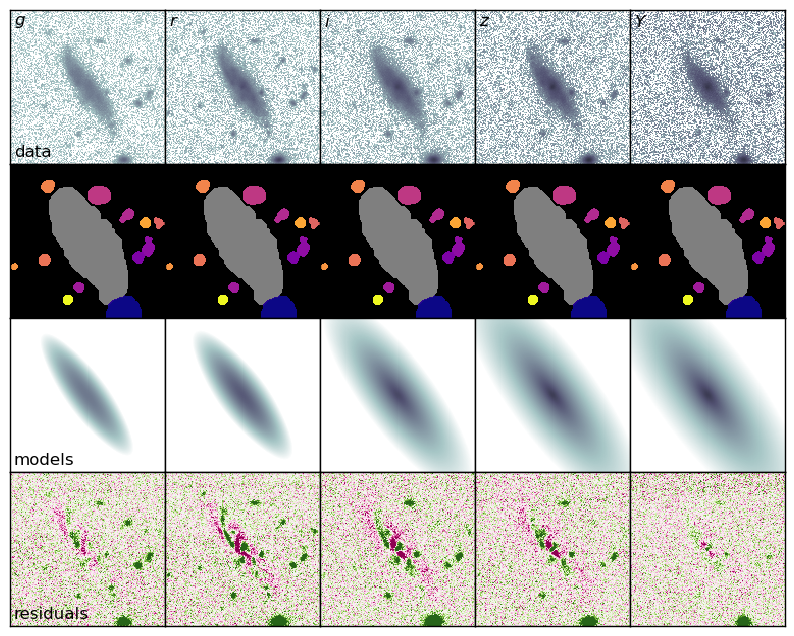

In [57]:
import matplotlib.pyplot as plt
from matplotlib import cm

universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum = 72
subfindid = 360895
camera = 'v0'

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'

img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
hdul = fits.open(img_name, mode='readonly')
out_name = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}.fits'
result = fits.open(out_name, mode='readonly')

segim = result['segim'].data
segid = result['segid'].data[0]

nrows=5
ncols=4
fig,axarr = plt.subplots(ncols,nrows,figsize=(nrows*2,ncols*2))
fig.subplots_adjust(wspace=0.,hspace=0.)
axarr = axarr.flatten()

for ax in axarr:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_linewidth(1.)
        ax.spines[spine].set_color('black')

for i,band in enumerate(['g','r','i','z','Y']):

    science = hdul[f'SUBARU_HSC.{band}'].data
    model = result[f'SUBARU_HSC.{band}.model_im'].data
    variance = hdul[f'SUBARU_HSC.{band} VARIANCE'].data
    residual = science - model
    
    sky_rms = np.mean(np.sqrt(variance[segim==0]))
    
    segim_1 = segim.astype(float)
    segim_1[segim_1==0] = np.nan
    cmap_1 = cm.plasma.copy()
    cmap_1.set_bad('black')
    
    segim_2 = segim.astype(float)
    segim_2[segim_2!=segid]=np.nan
    segim_2[segim_2==segid]=0.5
    cmap_2 = cm.binary.copy()
    cmap_2.set_bad('None')

    axes = axarr[i:(nrows-1)*ncols+1+i:5]
        
    axes[0].imshow(
        22.5-2.5*np.log10(science/0.167**2), aspect='auto', 
        vmin=18, vmax=30, origin='lower', cmap='bone',interpolation='None'
    )
    axes[0].text(
        0.025,0.975,f'${band}$',transform=axes[0].transAxes,
        ha='left',va='top', fontsize=12
    )
    axes[1].imshow(
        segim_1, origin='lower', cmap=cmap_1, aspect='auto'
    )
    axes[1].imshow(
        segim_2, origin='lower', cmap=cmap_2, vmin=0, vmax=1, aspect='auto'
    )
    axes[2].imshow(
        22.5-2.5*np.log10(model/0.167**2), aspect='auto', vmin=18, vmax=30, 
        origin='lower',cmap='bone',interpolation='None'
    )
    axes[3].imshow(
        residual, origin='lower', vmin=-3*sky_rms, vmax=3*sky_rms, 
        cmap='PiYG',interpolation='None',aspect='auto'
    )
    
axarr[0].text(
    0.025,0.025,f'data',transform=axarr[0].transAxes,
    ha='left',va='bottom', fontsize=12
)
axarr[10].text(
    0.025,0.025,f'models',transform=axarr[10].transAxes,
    ha='left',va='bottom', fontsize=12
)
axarr[15].text(
    0.025,0.025,f'residuals',transform=axarr[15].transAxes,
    ha='left',va='bottom', fontsize=12
)
    
fig.savefig('./test.pdf',bbox_inches='tight')

In [17]:
from astropy.io import fits
from astropy.cosmology import Planck15 as cosmo
import numpy as np
import mymysql
import morph
import os, sys, time, copy
api_key = os.environ['TNG_API_KEY']
scratch_path = os.environ['MYSCRATCH']

universe = 'IllustrisTNG'
simulation = 'TNG50-1'

database = 'IllustrisTNG50_1'
table = 'Morphologies_ProFit_HSC_Sersic'
cnf_path = '~/.mysql/ningaloo.cnf'
db_commit=True

snapnum = 72 # 91 
subfindid = 360895 # 391507 
band = 'i'
camera = 'v0'

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'
if not os.access(img_path,0): 
    os.system(f'mkdir -p {img_path}')

# check if database entry exists
# update band list to fit/submit

record_init = {
    'SnapNum': snapnum,
    'SubfindID': subfindid,
    'Camera': camera,
    'Band': band,
    'ProcessFlag': -1,
}

db_init = ' '.join([
    f'INSERT INTO {table} SET',
    f'SnapNum={record_init["SnapNum"]},',
    f'SubfindID={record_init["SubfindID"]},',
    f'Camera="{record_init["Camera"]}",',
    f'Band="{record_init["Band"]}",',
    f'ProcessFlag={record_init["ProcessFlag"]}'
])

if db_commit:
    try:
        mymysql.submit(db_init,database=database,cnf_path=cnf_path)
    except:
        raise
        # give warning and remove band from list
        print(f'Table {table} already contains {snapnum}-{subfindid}-{camera} in {band}-band. Skipping...\n')
        #return(None)
            
img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
out_name = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}_{band}.fits'

if not os.access(out_name,0):

    if not os.access(img_name,0):
        base_url = f'http://www.tng-project.org/api'
        img_url = f'{base_url}/{simulation}/snapshots/{snapnum}/subhalos/{subfindid}/skirt/skirt_images_hsc_realistic_{camera}.fits'
        sys_cmd = f'wget -nc -nv --content-disposition --header="API-Key:{api_key}" "{img_url}" -P {img_path}'
        os.system(sys_cmd)
    
    # Pass target image to R
    os.environ['IMG_NAME'] = img_name
    os.environ['UNIVERSE'] = universe
    os.environ['SIMULATION'] = simulation
    os.environ['SNAPNUM'] = str(snapnum)
    os.environ['SUBFINDID'] = str(subfindid)
    os.environ['CAMERA'] = camera
    os.environ['BAND'] = f'SUBARU_HSC.{band.capitalize()}'
    os.environ['OUT_NAME'] = out_name
    
    os.system('Rscript profit_sersic.r')

print('got here')

# append profit results to dictionary
hdul_in = fits.open(img_name,mode='readonly')
header = hdul_in[f'SUBARU_HSC.{band}'].header
hdul_out = fits.open(out_name,mode='readonly')

record = {
    'Redshift': float(header["redshift"]),
    'ApparentMagnitude': float(header["apmag"]),
    'RightAscention': float(header["ra"]),
    'Declination': float(header["dec"]),
    'ProcessFlag': -1,
}

# long form column names (e.g. sersic.nser)
columns = hdul_out[f'SUBARU_HSC.{band}.posterior'].columns.names
cols = [col.replace('sersic.','') for col in columns]

# maximum likelihood params
r = hdul_out[f'SUBARU_HSC.{band}.best'].data
print(r)
record['Sersic_xcen'] = r[0]
record['Sersic_ycen'] = r[1]
record['Sersic_mag'] = r[2]
record['Sersic_re'] = 10**r[3]
record['Sersic_nser'] = 10**r[4]
record['Sersic_ang'] = r[5]
record['Sersic_axrat'] = 10**r[6]

# posterior chain params
r = hdul_out[f'SUBARU_HSC.{band}.posterior'].data

for i,col in enumerate(cols):
    # these columns are in log units
    if col in ['re','nser','axrat']:
        chain = 10**r[f'sersic.{col}']
    else:
        chain = r[f'sersic.{col}']
    record[f'Sersic_{col}_med'] = np.median(chain)
    record[f'Sersic_{col}_std'] = np.std(chain,ddof=1)
    record[f'Sersic_{col}_p84'] = np.percentile(chain,84)-record[f'Sersic_{col}_med']
    record[f'Sersic_{col}_m16'] = np.percentile(chain,16)-record[f'Sersic_{col}_med']

img = hdul_in[f'SUBARU_HSC.{band}'].data
var = hdul_in[f'SUBARU_HSC.{band} VARIANCE'].data
segim = hdul_out['segim'].data
segid = hdul_out['segid'].data[0]
model = hdul_out[f'SUBARU_HSC.{band}.model_im'].data
psf = hdul_in[f'SUBARU_HSC.{band} PSF'].data
residual = img-model

# compute chi2nu for sersic fit (model dof = 7)
mask = (segim==segid) | (segim==0)
chi2nu = np.sum(residual[mask]**2/var[mask])/(np.sum(mask)-7)
record['ReducedChiSquared'] = chi2nu

# profound data (segmap, target id, and measurements)
segim_primary = segim==segid # target object
segim_secondary = (segim!=0) & (segim!=segid) # other non-sky objects
cols = hdul_out[f'SUBARU_HSC.{band}.profound'].columns.names
r = hdul_out[f'SUBARU_HSC.{band}.profound'].data
rownum = np.argwhere(r['segID']==segid)[0][0]
r = r[rownum]
for col in cols:
    if col not in ['RAcen','Deccen','RAmax','Decmax']:
        record[f'ProFound_{col}'] = r[col]

moments = morph.image_moments(img, segim, segid)
pixscale = header['FOVARC']/header['NAXIS1']
redshift = header['REDSHIFT']

# non-parametric morphologies using profound segmap
npmorph = morph.nonparametric(
    data = img, variance = var, segmentation = segim, model = model, 
    residual = residual, primary_mask = segim_primary, secondary_mask = segim_secondary,
    moments = moments, psf = psf, pixel_scale = pixscale, redshift = redshift, cosmology = cosmo
)

# elliptical and circular sizes
record['RPetro_Elliptical'] = npmorph.rp_ellipse
record['RPetro_Circular'] = npmorph.rp_circle
record['RMax_Elliptical'] = npmorph.rmax_ellipse
record['RMax_Circular'] = npmorph.rmax_circle
record['R80_Elliptical'] = npmorph.r80_ellipse
record['R80_Circular'] = npmorph.r80_circle
record['R50_Elliptical'] = npmorph.r50_ellipse
record['R50_Circular'] = npmorph.r50_circle
record['R20_Elliptical'] = npmorph.r20_ellipse
record['R20_Circular'] = npmorph.r20_circle

# quantities derived from the image / segim only
record['Asymmetry_xcen'] = npmorph.asymmetry_center[0]
record['Asymmetry_ycen'] = npmorph.asymmetry_center[1]
record['Asymmetry'] = npmorph.asymmetry_cas
record['AsymmetryBkgDens'] = npmorph.bkg_asymmetry_density
record['RMSAsymmetrySquared'] = npmorph.asymmetry_rms2
record['OuterAsymmetry'] = npmorph.asymmetry_outer
record['ShapeAsymmetry'] = npmorph.asymmetry_shape
record['AsymmetryNoAperture_xcen'] = npmorph.asymmetry_center_nap[0]
record['AsymmetryNoAperture_ycen'] = npmorph.asymmetry_center_nap[1]
record['AsymmetryNoAperture'] = npmorph.asymmetry_cas_nap
record['Concentration_Elliptical'] = npmorph.concentration_ellipse
record['Concentration_Circular'] = npmorph.concentration_circle
record['Smoothness'] = npmorph.smoothness
record['SmoothnessBkgDens'] = npmorph.bkg_smoothness_density
record['Gini'] = npmorph.gini
record['M20'] = npmorph.m20
record['SB1kpc'] = npmorph.sb_1kpc

# model-dependent quantities computed from residuals
record['ResidualAsymmetry_xcen'] = npmorph.asymmetry_residual_center[0]
record['ResidualAsymmetry_ycen'] = npmorph.asymmetry_residual_center[1]
record['ResidualAsymmetry'] = npmorph.asymmetry_residual
record['ResidualAsymmetryNoAperture_xcen'] = npmorph.asymmetry_residual_center_nap[0]
record['ResidualAsymmetryNoAperture_ycen'] = npmorph.asymmetry_residual_center_nap[1]
record['ResidualAsymmetryNoAperture'] = npmorph.asymmetry_residual_nap

record['ProcessFlag']=0

db_update = [
    f'UPDATE {table} SET'
]

for key in record.keys():
    if type(record[key]) is str:
        db_update += [f'{key}="{record[key]}"']
    else:
        db_update += [f'{key}={record[key]}']

    if key != list(record.keys())[-1]:
        db_update += [',']
        
db_update += [
    f'WHERE SnapNum={snapnum}',
    f'AND SubfindID={subfindid}',
    f'AND Camera="{camera}"',
    f'AND Band="{band}"'
]

if db_commit:
    
    mymysql.submit(' '.join(db_update),database=database,cnf_path=cnf_path)


Loading required package: Rfits
Loading required package: magicaxis
Loading required package: Rcpp
dim(image)[1]/box[1] must be >=3, box[1] modified to 51
dim(image)[2]/box[2] must be >=3, box[2] modified to 51
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 51
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 51
dim(image)[1]/box[1] must be >=3, box[1] modified to 51
dim(image)[2]/box[2] must be >=3, box[2] modified to 51
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 51
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 51
dim(image)[1]/box[1] must be >=3, box[1] modified to 51
dim(image)[2]/box[2] must be >=3, box[2] modified to 51
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 51
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 51
dim(image)[1]/box[1] must be >=3, box[1] modified to 51
dim(image)[2]/box[2] must be >=3, box[2] modified to 51
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 51
dim(image)[2]/grid[2] must be >=3, grid[2] modi


Laplace's Demon was called on Wed Sep 11 16:30:22 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -11798.3
Iteration: 200,   Proposal: Componentwise,   LP: -11798.5

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 1: -11797.447 75.89 75.684 19.183 1.343 0.088 36.527 -0.522
Iteration 2
CMA 2: -11794.09 75.889 75.687 19.173 1.348 0.098 36.451 -0.525



Laplace's Demon was called on Wed Sep 11 16:30:50 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -11797.2
Iteration: 200,   Proposal: Componentwise,   LP: -11795.9

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


Iteration 3



Laplace's Demon was called on Wed Sep 11 16:31:18 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -11796.7
Iteration: 200,   Proposal: Componentwise,   LP: -11796.4

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


Iteration 4



Laplace's Demon was called on Wed Sep 11 16:31:46 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -11795.3
Iteration: 200,   Proposal: Componentwise,   LP: -11796.7

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 4: -11794.07 75.889 75.687 19.173 1.348 0.098 36.459 -0.525
Iteration 5



Laplace's Demon was called on Wed Sep 11 16:32:14 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -11798
Iteration: 200,   Proposal: Componentwise,   LP: -11796.5
Iteration: 300,   Proposal: Componentwise,   LP: -11797.6
Iteration: 400,   Proposal: Componentwise,   LP: -11799.8
Iteration: 500,   Proposal: Componentwise,   LP: -11797
Iteration: 600,   Proposal: Componentwise,   LP: -11798.7
Iteration: 700,   Proposal: Componentwise,   LP: -11795.6
Iteration: 800,   Proposal: Componentwise,   LP: -11799
Iteration: 900,   Proposal: Componentwise,   LP: -11795.4
Iteration: 1000,   Proposal: Componentwise,   LP: -11797

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.
[CRAYBLAS_WARNING] Application linked against multiple cray-libsci libraries
got here
[75.889496   75.68663    19.173426    1.347799

In [62]:
dic = {'a':0,'b':2,'c':4}

cmd = [f'{key}={dic[key]}' for key in dic.keys()]
print(cmd)

['a=0', 'b=2', 'c=4']


/tmp/ipykernel_2282672/3117165979.py:64: RuntimeWarning: invalid value encountered in log10
  22.5-2.5*np.log10(science/0.167**2), aspect='auto',


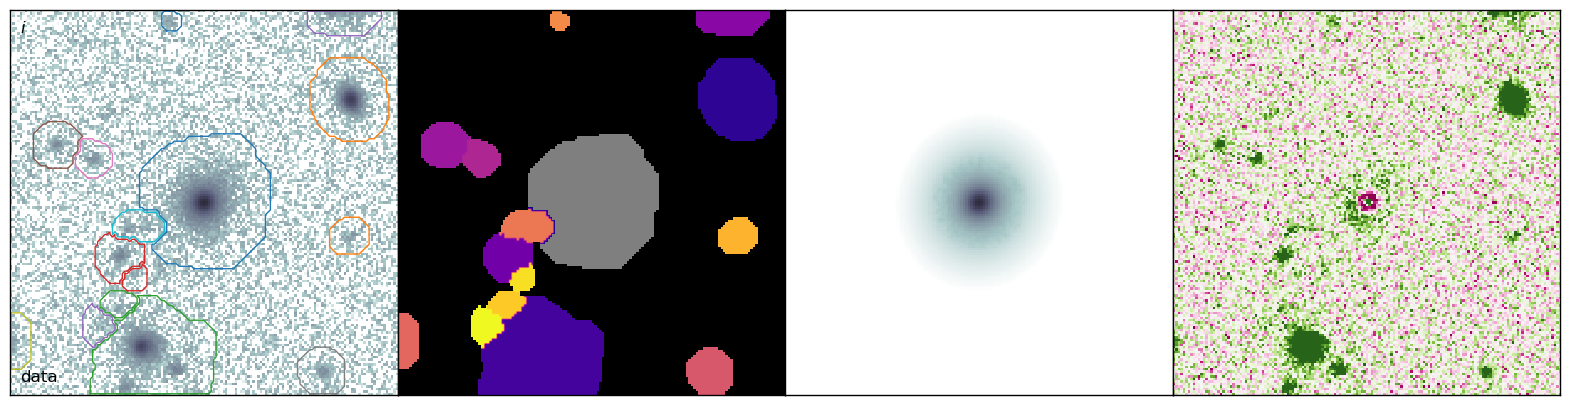

In [6]:
from astropy.io import fits
import numpy as np
import pymysql
import morph
import os, sys, time
api_key = os.environ['TNG_API_KEY']
scratch_path = os.environ['MYSCRATCH']

import matplotlib.pyplot as plt
from matplotlib import cm

universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum=91
subfindid=838925
camera='v1'
band='i'

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'

img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
hdul = fits.open(img_name, mode='readonly')
out_name = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}_{band}.fits'
result = fits.open(out_name, mode='readonly')

segim = result['segim'].data
segid = result['segid'].data[0]

nrows=1
ncols=4
fig,axarr = plt.subplots(nrows,ncols,figsize=(ncols*5,nrows*5))
fig.subplots_adjust(wspace=0.,hspace=0.)
axarr = axarr.flatten()

for ax in axarr:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_linewidth(1.)
        ax.spines[spine].set_color('black')

science = hdul[f'SUBARU_HSC.{band}'].data
variance = hdul[f'SUBARU_HSC.{band} VARIANCE'].data
model = result[f'SUBARU_HSC.{band}.model_im'].data
residual = science - model
sky_rms = np.mean(np.sqrt(variance[segim==0]))

segim_1 = segim.astype(float)
segim_1[segim_1==0] = np.nan
cmap_1 = cm.plasma.copy()
cmap_1.set_bad('black')

segim_2 = segim.astype(float)
segim_2[segim_2!=segid]=np.nan
segim_2[segim_2==segid]=0.5
cmap_2 = cm.binary.copy()
cmap_2.set_bad('None')

axes = axarr.flatten()
    
axes[0].imshow(
    22.5-2.5*np.log10(science/0.167**2), aspect='auto', 
    vmin=18, vmax=30, origin='lower', cmap='bone',interpolation='None'
)
axes[0].text(
    0.025,0.975,f'${band}$',transform=axes[0].transAxes,
    ha='left',va='top', fontsize=12
)

morph.plot_segim_contours(axes[0],segim)

axes[1].imshow(
    segim_1, origin='lower', cmap=cmap_1, aspect='auto'
)
axes[1].imshow(
    segim_2, origin='lower', cmap=cmap_2, vmin=0, vmax=1, aspect='auto'
)
axes[2].imshow(
    22.5-2.5*np.log10(model/0.167**2), aspect='auto', vmin=18, vmax=30, 
    origin='lower',cmap='bone',interpolation='None'
)
axes[3].imshow(
    residual, origin='lower', vmin=-3*sky_rms, vmax=3*sky_rms, 
    cmap='PiYG',interpolation='None',aspect='auto'
)
    
axarr[0].text(
    0.025,0.025,f'data',transform=axarr[0].transAxes,
    ha='left',va='bottom', fontsize=12
)
# axarr[10].text(
#     0.025,0.025,f'models',transform=axarr[10].transAxes,
#     ha='left',va='bottom', fontsize=12
# )
# axarr[15].text(
#     0.025,0.025,f'residuals',transform=axarr[15].transAxes,
#     ha='left',va='bottom', fontsize=12
# )

fig.savefig('./test.pdf',bbox_inches='tight')

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


In [1]:
from astropy.io import fits
from astropy.cosmology import Planck15 as cosmo
import numpy as np
import mymysql
import morph
import os, sys, time, copy, itertools

# global paths/credentials for all jobs
api_key = os.environ['TNG_API_KEY']
scratch_path = os.environ['MYSCRATCH']
software_path = os.environ['MYSOFTWARE']
cnf_path = '~/.mysql/ningaloo.cnf'

def ProFit_HSC_Sersic(
    universe, simulation, snapnum, subfindid,
    camera, band, img_path, 
    db_commit, database, table,
):

    # Primary key for database table
    databaseid = f'{snapnum:03}.{subfindid}.{camera}.{band}'

    # Initialization command for record on database
    dbcmd = ' '.join([
        f'INSERT INTO {table} SET',
        f'DatabaseID="{databaseid}",',
        f'SnapNum={snapnum},',
        f'SubfindID={subfindid},',
        f'Camera="{camera}",',
        f'Band="{band}",',
        f'ProcessFlag=-1'
    ])

    # Check if database entry exists, add new entry if not
    if db_commit:
        try:
            mymysql.submit(dbcmd,database=database,cnf_path=cnf_path)
        except:
            print(f'Table {table} already contains {databaseid}. Skipping...\n')
            return
                
    img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
    out_name = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}_{band}.fits'

    record = {'ProcessFlag': 0,}

    # Download image if not already available
    if not os.access(img_name,0):
        base_url = f'http://www.tng-project.org/api'
        img_url = f'{base_url}/{simulation}/snapshots/{snapnum}/subhalos/{subfindid}/skirt/skirt_images_hsc_realistic_{camera}.fits'
        sys_cmd = f'wget -nc -nv --content-disposition --header="API-Key:{api_key}" "{img_url}" -P {img_path}'
        os.system(sys_cmd)

    # Check that image is complete after download
    try: 
        hdul_in = fits.open(img_name,mode='readonly')
        header = hdul_in[f'SUBARU_HSC.{band}'].header  
        img = hdul_in[f'SUBARU_HSC.{band}'].data
        var = hdul_in[f'SUBARU_HSC.{band} VARIANCE'].data
        psf = hdul_in[f'SUBARU_HSC.{band} PSF'].data
    except:
        # Flag image download as unsuccessful
        record['ProcessFlag']=2**3
        if db_commit:
            dbcmd = mysql_table_update_cmd(record, table, databaseid)
            mymysql.submit(dbcmd, database=database, cnf_path=cnf_path)
        return  

    record['Redshift'] = float(header["redshift"])
    record['ApparentMagnitude'] = float(header["apmag"])
    record['RightAscension'] = float(header["ra"])
    record['Declination'] = float(header["dec"])

    # Run Pro-tools on image in R
    if not os.access(out_name,0):
        os.environ['IMG_NAME'] = img_name
        os.environ['UNIVERSE'] = universe
        os.environ['SIMULATION'] = simulation
        os.environ['SNAPNUM'] = str(snapnum)
        os.environ['SUBFINDID'] = str(subfindid)
        os.environ['CAMERA'] = camera
        os.environ['BAND'] = f'SUBARU_HSC.{band.capitalize()}'
        os.environ['OUT_NAME'] = out_name
        os.system('Rscript Morphologies_ProFit_HSC_Sersic.r')

    try: 
        hdul_out = fits.open(out_name, mode='readonly')
    except:
        # Flag if parametric fitting was unsuccessful
        record['ProcessFlag']+=2**0
        if db_commit: 
            dbcmd = mysql_table_update_cmd(record, table, databaseid)
            mymysql.submit(dbcmd, database=database, cnf_path=cnf_path)
        return
    
    # Long form column names (e.g. sersic.nser), convert to short
    columns = hdul_out[f'SUBARU_HSC.{band}.posterior'].columns.names
    cols = [col.replace('sersic.','') for col in columns]
    
    # maximum likelihood params
    r = hdul_out[f'SUBARU_HSC.{band}.best'].data
    record['Sersic_xcen'] = r[0]
    record['Sersic_ycen'] = r[1]
    record['Sersic_mag'] = r[2]
    record['Sersic_re'] = 10**r[3]
    record['Sersic_nser'] = 10**r[4]
    record['Sersic_ang'] = r[5]
    record['Sersic_axrat'] = 10**r[6]
    
    # posterior chain params
    r = hdul_out[f'SUBARU_HSC.{band}.posterior'].data
    
    for i,col in enumerate(cols):
        # these columns are in log units
        if col in ['re','nser','axrat']:
            chain = 10**r[f'sersic.{col}']
        else:
            chain = r[f'sersic.{col}']
        record[f'Sersic_{col}_med'] = np.median(chain)
        record[f'Sersic_{col}_std'] = np.std(chain,ddof=1)
        record[f'Sersic_{col}_p84'] = np.percentile(chain,84)-record[f'Sersic_{col}_med']
        record[f'Sersic_{col}_m16'] = np.percentile(chain,16)-record[f'Sersic_{col}_med']

    segim = hdul_out['segim'].data
    segid = hdul_out['segid'].data[0]
    model = hdul_out[f'SUBARU_HSC.{band}.model_im'].data
    residual = img-model
    
    # compute chi2nu for sersic fit (model dof = 7)
    model_ndof = 7
    mask = (segim==segid) | (segim==0)
    chi2nu = np.sum(residual[mask]**2/var[mask])/(np.sum(mask)-model_ndof)
    record['ReducedChiSquared'] = chi2nu
    
    # profound data (segmap, target id, and measurements)
    segim_primary = segim==segid # target object
    segim_secondary = (segim!=0) & (segim!=segid) # other non-sky objects
    cols = hdul_out[f'SUBARU_HSC.{band}.profound'].columns.names
    r = hdul_out[f'SUBARU_HSC.{band}.profound'].data
    rownum = np.argwhere(r['segID']==segid)[0][0]
    r = r[rownum]
    for col in cols:
        if col not in ['RAcen','Deccen','RAmax','Decmax']:
            record[f'ProFound_{col}'] = r[col]

    moments = morph.image_moments(img, segim, segid)
    pixscale = header['FOVARC']/header['NAXIS1']
    redshift = header['REDSHIFT']

    try:
        # Non-parametric morphologies using profound segmap
        npmorph = morph.nonparametric(
            data = img, variance = var, segmentation = segim, model = model, 
            residual = residual, primary_mask = segim_primary, secondary_mask = segim_secondary,
            moments = moments, psf = psf, pixel_scale = pixscale, redshift = redshift, cosmology = cosmo
        )
    except:
        # Flag that non-parametric calculations were unsuccessful
        record['ProcessFlag']+=2**1
        if db_commit:
            dbcmd = mysql_table_update_cmd(record, table, databaseid)
            mymysql.submit(dbcmd,database=database,cnf_path=cnf_path)
        return
    
    # elliptical and circular sizes
    record['RPetro_Elliptical'] = npmorph.rp_ellipse
    record['RPetro_Circular'] = npmorph.rp_circle
    record['RMax_Elliptical'] = npmorph.rmax_ellipse
    record['RMax_Circular'] = npmorph.rmax_circle
    record['R80_Elliptical'] = npmorph.r80_ellipse
    record['R80_Circular'] = npmorph.r80_circle
    record['R50_Elliptical'] = npmorph.r50_ellipse
    record['R50_Circular'] = npmorph.r50_circle
    record['R20_Elliptical'] = npmorph.r20_ellipse
    record['R20_Circular'] = npmorph.r20_circle
    
    # quantities derived from the image / segim only
    record['Asymmetry_xcen'] = npmorph.asymmetry_center[0]
    record['Asymmetry_ycen'] = npmorph.asymmetry_center[1]
    record['Asymmetry'] = npmorph.asymmetry_cas
    record['AsymmetryBkgDens'] = npmorph.bkg_asymmetry_density
    record['RMSAsymmetrySquared'] = npmorph.asymmetry_rms2
    record['OuterAsymmetry'] = npmorph.asymmetry_outer
    record['ShapeAsymmetry'] = npmorph.asymmetry_shape
    record['AsymmetryNoAperture_xcen'] = npmorph.asymmetry_center_nap[0]
    record['AsymmetryNoAperture_ycen'] = npmorph.asymmetry_center_nap[1]
    record['AsymmetryNoAperture'] = npmorph.asymmetry_cas_nap
    record['Concentration_Elliptical'] = npmorph.concentration_ellipse
    record['Concentration_Circular'] = npmorph.concentration_circle
    record['Smoothness'] = npmorph.smoothness
    record['SmoothnessBkgDens'] = npmorph.bkg_smoothness_density
    record['Gini'] = npmorph.gini
    record['M20'] = npmorph.m20
    record['SB1kpc'] = npmorph.sb_1kpc
    
    # model-dependent quantities computed from residuals
    record['ResidualAsymmetry_xcen'] = npmorph.asymmetry_residual_center[0]
    record['ResidualAsymmetry_ycen'] = npmorph.asymmetry_residual_center[1]
    record['ResidualAsymmetry'] = npmorph.asymmetry_residual
    record['ResidualAsymmetryNoAperture_xcen'] = npmorph.asymmetry_residual_center_nap[0]
    record['ResidualAsymmetryNoAperture_ycen'] = npmorph.asymmetry_residual_center_nap[1]
    record['ResidualAsymmetryNoAperture'] = npmorph.asymmetry_residual_nap

    if db_commit:
        try:
            dbcmd = mysql_table_update_cmd(record, table, databaseid)
            mymysql.submit(dbcmd,database=database,cnf_path=cnf_path)
        except:
            print(f'Could not add full record for {databaseid} to {table}. Skipping...\n')

    return
        

def mysql_table_update_cmd(
    record, table, databaseid,
):
    db_update = [
        f'UPDATE {table} SET'
    ]
    
    for key in record.keys():
        if type(record[key]) is str:
            db_update += [f'{key}="{record[key]}"']
        else:
            db_update += [f'{key}={record[key]}']
    
        if key != list(record.keys())[-1]:
            db_update += [',']
            
    db_update += [
        f'WHERE DatabaseID="{databaseid}"'
    ]
    return(' '.join(db_update))


def main_array():

    # Simulation identifiers
    universe = os.environ['UNIVERSE'] #'IllustrisTNG'
    simulation = os.environ['SIMULATION'] #'TNG50-1'

    # Mysql table identifiers
    database = os.environ['DATABASE'] # 'IllustrisTNG50_1'
    table = os.environ['TABLE'] # 'Morphologies_ProFit_HSC_Sersic']
    # Commit results to database?
    db_commit=True

    # Read in job array size, id from environment
    job_array_id = int(os.environ['JOB_ARRAY_INDEX'])
    job_array_size = int(os.environ['JOB_ARRAY_SIZE'])

    # Set limits of snapnum, choose subhalos
    snapmin,snapmax = 72,91
    snapnums = np.arange(snapmin,snapmax+1)
    logmstar_min = 9.
    logmstar_max = 99.

    # Camera angles and bands (independent tasks)
    cameras = ['v0','v1','v2','v3']
    bands = ['g','r','i','z','y']

    # Loop over snapshots, setting tasks for each job
    for snapnum in snapnums:

        # Set up paths to image directories
        virgotng_path = f'{scratch_path}/Simulations/virgotng'
        sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
        img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'
        if not os.access(img_path,0): 
            os.system(f'mkdir -p {img_path}')
        
        dbcmd = [
            f'SELECT SubfindID from Subhalos',
            f'WHERE SnapNum={snapnum}',
            f'AND SubhaloMassType_stars>={logmstar_min}',
            f'AND SubhaloMassType_stars<{logmstar_max}',
        ]
        subfindids = mymysql.query(
            ' '.join(dbcmd), database=database, cnf_path=cnf_path
        ).flatten()

        # All processing tasks for this snapnum
        iterables = np.array(list(itertools.product(subfindids,cameras,bands)))
        # Processing tasks for this job
        iterables = iterables[job_array_id::job_array_size]

        # Loop over tasks assigned to this job
        for iterable in iterables:
            subfindid = int(iterable[0])
            camera = iterable[1]
            band = iterable[2]

            ProFit_HSC_Sersic(
                universe=universe, simulation=simulation, snapnum=snapnum, subfindid=subfindid,
                camera=camera, band=band, img_path=img_path, db_commit=db_commit, 
                database=database, table=table,
            )
            

def main_mpi():

    from mpi4py import MPI

    # Read in job array size, id from environment
    # used to partition data for mpi processes
    array_size = 128 #int(os.environ['JOB_ARRAY_SIZE'])
    array_rank = 0 #int(os.environ['JOB_ARRAY_INDEX'])

    # For each array job, get mpi size and rank
    mpi_size = 1 #MPI.COMM_WORLD.Get_size()
    mpi_rank = MPI.COMM_WORLD.Get_rank()
    mpi_name = MPI.Get_processor_name()

    # Simulation identifiers
    universe = 'IllustrisTNG' # os.environ['UNIVERSE'] 
    simulation = 'TNG50-1' # os.environ['SIMULATION'] 

    # Mysql table identifiers
    database = 'IllustrisTNG50_1' # os.environ['DATABASE'] 
    table = 'Morphologies_ProFit_HSC_Sersic' # os.environ['TABLE'] 
    # Commit results to database?
    db_commit=True

    # Set limits of snapnum, choose subhalos
    snapmin = 72
    snapmax = 91
    logmstar_min = 9.
    logmstar_max = 99.

    # Camera angles and bands (independent tasks)
    cameras = ['v0','v1','v2','v3']
    bands = ['g','r','i','z','y']
    
    dbcmd = ' '.join([
        f'SELECT SnapNum,SubfindID from Subhalos',
        f'WHERE SnapNum>={snapmin} and SnapNum<={snapmax}',
        f'AND SubhaloMassType_stars>={logmstar_min}',
        f'AND SubhaloMassType_stars<{logmstar_max}',
        f'ORDER BY snapnum,subfindid'
    ])
    df = mymysql.query_df(dbcmd, database=database, cnf_path=cnf_path)
    indices = np.array(df.index)
    
    # Create set of iterables for this job in array
    iters = np.array(list(itertools.product(indices,cameras,bands)))
    array_iters = iters[array_rank::array_size]

    # Get iterables for this specific mpi process 
    mpi_iters = array_iters[mpi_rank::mpi_size]
        
    # Loop over tasks assigned to this mpi process
    for iterable in mpi_iters[::-1]:
        
        index = int(iterable[0])
        row = df.loc[index]
        snapnum = row['SnapNum']
        subfindid = row['SubfindID']
        camera = iterable[1]
        band = iterable[2]

        print(snapnum,subfindid,camera,band)
    
        # Set up paths to image directories
        virgotng_path = f'{scratch_path}/Simulations/virgotng'
        sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
        img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'
        
        if not os.access(img_path,0): 
            os.system(f'mkdir -p {img_path}')
            
        ProFit_HSC_Sersic(
            universe=universe, simulation=simulation, snapnum=snapnum, subfindid=subfindid,
            camera=camera, band=band, img_path=img_path, db_commit=db_commit, 
            database=database, table=table,
        )
    
def main_single():

    # Simulation identifiers
    universe = 'IllustrisTNG'
    simulation = 'TNG50-1'

    # Mysql table identifiers
    database = 'IllustrisTNG50_1'
    table = 'Morphologies_ProFit_HSC_Sersic'
    # Commit results to database?
    db_commit=True

    snapnum=73
    subfindid=52763
    camera='v0'
    band='y'

    # Set up paths to image directories
    virgotng_path = f'{scratch_path}/Simulations/virgotng'
    sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
    img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'
    if not os.access(img_path,0): 
        os.system(f'mkdir -p {img_path}')

    ProFit_HSC_Sersic(
        universe=universe, simulation=simulation, snapnum=snapnum, subfindid=subfindid,
        camera=camera, band=band, img_path=img_path, db_commit=db_commit, 
        database=database, table=table,
    )

if __name__=='__main__':

    main_mpi()

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


       SnapNum  SubfindID
0           84          0
1           84          1
2           84          2
3           84          3
4           84          4
...        ...        ...
24112       91     793773
24113       91     800644
24114       91     825528
24115       91     838925
24116       91     897490

[24117 rows x 2 columns]
91 897490 v3 y


2024-09-13 22:51:05 URL:https://data-eu.tng-project.org/file/skirt_images_hsc_realistic_v3/L35n2160TNG/91/897490/?token=4298921f8f3bbc0e22dd [2160000/2160000] -> "/scratch/pawsey0119/bottrell/Simulations/virgotng/data/IllustrisTNG/TNG50-1/postprocessing/skirt_images_hsc/realistic/091/shalo_091-897490_v3_HSC_GRIZY.fits" [1]
Loading required package: Rfits
Loading required package: magicaxis
Loading required package: Rcpp
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 53
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 53
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 53
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 53
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(imag


Laplace's Demon was called on Fri Sep 13 22:55:41 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -954
Iteration: 200,   Proposal: Componentwise,   LP: -958.3

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 1: -949.357 78.837 78.555 20.263 0 -0.088 41.165 -0.207
Iteration 2
CMA 2: -947.979 78.826 78.554 20.262 0 -0.115 42.704 -0.17



Laplace's Demon was called on Fri Sep 13 23:01:27 2024

Performing initial checks...
     Derivatives may be problematic if used.
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -955.6
Iteration: 200,   Proposal: Componentwise,   LP: -951.3

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 2: -947.921 78.826 78.554 20.262 0 -0.115 42.786 -0.17
Iteration 3
CMA 3: -947.415 78.826 78.556 20.264 0 -0.093 43.809 -0.189



Laplace's Demon was called on Fri Sep 13 23:10:00 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -946.2
Iteration: 200,   Proposal: Componentwise,   LP: -944.5

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 3: -943.597 78.831 78.559 20.257 0 0.001 50.91 -0.225
Iteration 4
CMA 4: -942.086 78.829 78.565 20.257 0 0.047 55.201 -0.233



Laplace's Demon was called on Fri Sep 13 23:18:09 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -942
Iteration: 200,   Proposal: Componentwise,   LP: -941.1

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 4: -939.877 78.824 78.566 20.252 0 0.067 62.624 -0.235
Iteration 5
CMA 5: -939.683 78.827 78.559 20.256 0 0.027 62.617 -0.233



Laplace's Demon was called on Fri Sep 13 23:25:20 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -940.9
Iteration: 200,   Proposal: Componentwise,   LP: -941.8
Iteration: 300,   Proposal: Componentwise,   LP: -944.9
Iteration: 400,   Proposal: Componentwise,   LP: -942.6
Iteration: 500,   Proposal: Componentwise,   LP: -941.8
Iteration: 600,   Proposal: Componentwise,   LP: -944.2
Iteration: 700,   Proposal: Componentwise,   LP: -943
Iteration: 800,   Proposal: Componentwise,   LP: -942.8
Iteration: 900,   Proposal: Componentwise,   LP: -941.7
Iteration: 1000,   Proposal: Componentwise,   LP: -945.3

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 5: -939.672 78.827 78.559 20.256 0 0.012 62.954 -0.233


[CRAYBLAS_WARNING] Application linked against multiple cray-libsci libraries
91 897490 v3 z


Loading required package: Rfits
Loading required package: magicaxis
Loading required package: Rcpp
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 53
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 53
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 53
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 53
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 53
dim(image)[2]/grid[2] must be >=3, grid[2] modified to 53
dim(image)[1]/box[1] must be >=3, box[1] modified to 53
dim(image)[2]/box[2] must be >=3, box[2] modified to 53
dim(image)[1]/grid[1] must be >=3, grid[1] modified to 53
dim(image)[2]/grid[2] must be >=3, grid[2] modi


Laplace's Demon was called on Fri Sep 13 23:39:56 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -1480.9
Iteration: 200,   Proposal: Componentwise,   LP: -1447.6

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 1: -1445.805 78.846 78.542 20.39 0 -0.301 48.69 -0.231
Iteration 2



Laplace's Demon was called on Fri Sep 13 23:42:08 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -1443.3
Iteration: 200,   Proposal: Componentwise,   LP: -1429.9

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 2: -1429.656 78.847 78.549 20.39 0 -0.301 53.734 -0.222
Iteration 3



Laplace's Demon was called on Fri Sep 13 23:43:24 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -1423.1
Iteration: 200,   Proposal: Componentwise,   LP: -1415.3

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 3: -1415.272 78.842 78.551 20.391 0 -0.301 62.478 -0.241
Iteration 4



Laplace's Demon was called on Fri Sep 13 23:45:20 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -1415.8
Iteration: 200,   Proposal: Componentwise,   LP: -1418

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 4: -1414.937 78.842 78.551 20.391 0 -0.301 63.231 -0.241
Iteration 5



Laplace's Demon was called on Fri Sep 13 23:47:04 2024

Performing initial checks...
Algorithm: Componentwise Hit-And-Run Metropolis 

Laplace's Demon is beginning to update...
Iteration: 100,   Proposal: Componentwise,   LP: -1416.3
Iteration: 200,   Proposal: Componentwise,   LP: -1417.6
Iteration: 300,   Proposal: Componentwise,   LP: -1418
Iteration: 400,   Proposal: Componentwise,   LP: -1417.6
Iteration: 500,   Proposal: Componentwise,   LP: -1416.6
Iteration: 600,   Proposal: Componentwise,   LP: -1415.8
Iteration: 700,   Proposal: Componentwise,   LP: -1418.3
Iteration: 800,   Proposal: Componentwise,   LP: -1416.5
Iteration: 900,   Proposal: Componentwise,   LP: -1416.4
Iteration: 1000,   Proposal: Componentwise,   LP: -1416.5

Assessing Stationarity
Assessing Thinning and ESS
Creating Summaries
Creating Output

Laplace's Demon has finished.


LD Mode 5: -1414.841 78.845 78.55 20.392 0 -0.301 64.169 -0.242


[CRAYBLAS_WARNING] Application linked against multiple cray-libsci libraries
91 897490 v3 i
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v3.i. Skipping...

91 897490 v3 r
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v3.r. Skipping...

91 897490 v3 g
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v3.g. Skipping...

91 897490 v2 y
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v2.y. Skipping...

91 897490 v2 z
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v2.z. Skipping...

91 897490 v2 i
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v2.i. Skipping...

91 897490 v2 r
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v2.r. Skipping...

91 897490 v2 g
Table Morphologies_ProFit_HSC_Sersic already contains 091.897490.v2.g. Skipping...



In [8]:
import numpy as np
import itertools

# Sample NumPy arrays
array1 = np.array([1, 2, 3])
array2 = np.array(['a', 'b'])

# Generate combinations using itertools.product
combinations = list(itertools.product(array1, array2))

# Convert combinations to a NumPy array
combinations_array = combinations

print(combinations_array)

[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b')]


[26.88065073 29.63636903]
flux: 0.16529804024803513
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True

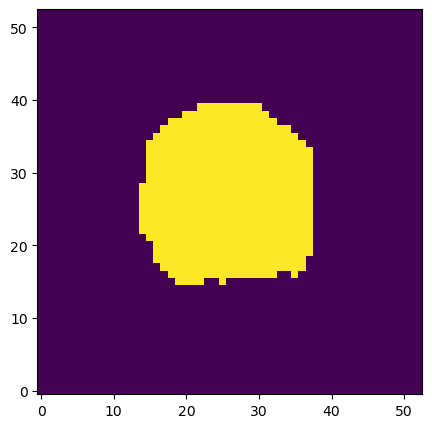

In [73]:
from astropy.io import fits
import numpy as np
import pymysql
import morph
import os, sys, time
api_key = os.environ['TNG_API_KEY']
scratch_path = os.environ['MYSCRATCH']

import matplotlib.pyplot as plt
from matplotlib import cm

universe = 'IllustrisTNG'
simulation = 'TNG50-1'
snapnum = 72
subfindid = 358817 # 406602 # 407765 # 391507
camera = 'v0'
band = 'g'

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic/{snapnum:03}'

img_name = f'{img_path}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
hdul = fits.open(img_name, mode='readonly')
out_name = f'{img_path}/profuse_{snapnum:03}-{subfindid}_{camera}_{band}.fits'
result = fits.open(out_name, mode='readonly')

segim = result['segim'].data
segid = result['segid'].data[0]
mask = segim==segid
data = hdul['SUBARU_HSC.G'].data

print(result['profound_stack'].data['xcen'])


fig,ax=plt.subplots(figsize=(5,5))
ax.imshow(mask,origin='lower')

rows, cols = np.where(mask)
M = np.sum(data[mask])
print('flux:',M)
fluxes_1 = data[tuple([rows,cols])]
fluxes_2 = data[rows,cols]
print(fluxes_1 == fluxes_2)
print(np.sum(fluxes_2))

xcen = np.sum(fluxes_1*cols)/M+0.5
ycen = np.sum(fluxes_1*rows)/M+0.5
print(xcen)
print(ycen)






In [2]:
from astropy.io import fits
import pandas as pd
import numpy as np
import pymysql
import morph
import mymysql
import os, sys, time

scratch_path = os.environ['MYSCRATCH']

import matplotlib.pyplot as plt
from matplotlib import cm

universe='IllustrisTNG'
simulation='TNG50-1'
database = 'IllustrisTNG50_1'
table = 'Morphologies_ProFit_HSC_Sersic'
snapnum=72

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic' #/{snapnum:03}'

dbcmd = f'select snapnum,subfindid,camera,band,profound_flux,profound_xcen,profound_ycen from {table} where processflag=0'
df = mymysql.query_df(dbcmd,database,cnf_path='/home/bottrell/.mysql/ningaloo.cnf')

df['moment_xcen'] = 0.
df['moment_ycen'] = 0.
df['moment_flux'] = 0.

df['profound0_xcen'] = 0.
df['profound0_ycen'] = 0.
df['profound0_flux'] = 0.

for idx in range(len(df)):

    rec = df.loc[idx]
    snapnum = rec['snapnum']
    subfindid = rec['subfindid']
    camera = rec['camera']
    band = rec['band']

    img_name = f'{img_path}/{snapnum:03}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
    hdul = fits.open(img_name, mode='readonly')
    out_name = f'{img_path}/{snapnum:03}/profuse_{snapnum:03}-{subfindid}_{camera}_{band}.fits'
    result = fits.open(out_name, mode='readonly')

    segim = result['segim'].data
    segid = result['segid'].data[0]
    data = hdul[f'SUBARU_HSC.{band}'].data

    profound = result[f'SUBARU_HSC.{band}.profound'].data
    rowidx = np.argwhere(profound['segID']==segid)[0][0]

    flux = result[f'SUBARU_HSC.{band}.profound'].data['flux'][rowidx]
    xbar = result[f'SUBARU_HSC.{band}.profound'].data['xcen'][rowidx]
    ybar = result[f'SUBARU_HSC.{band}.profound'].data['ycen'][rowidx]

    df.loc[idx,'profound0_flux'] = flux
    df.loc[idx,'profound0_xcen'] = xbar
    df.loc[idx,'profound0_ycen'] = ybar

    mask = segim==segid
    rows, cols = np.where(mask)
    fluxes = data[rows,cols]
    flux = np.sum(fluxes)
    xbar = np.sum(cols*fluxes)/flux + 0.5
    ybar = np.sum(rows*fluxes)/flux + 0.5
    
    df.loc[idx,'moment_flux'] = flux
    df.loc[idx,'moment_xcen'] = xbar
    df.loc[idx,'moment_ycen'] = ybar
    
    



# fig,ax=plt.subplots(figsize=(5,5))
# ax.imshow(mask,origin='lower')

# rows, cols = np.where(mask)
# M = np.sum(data[mask])
# print('flux:',M)
# fluxes_1 = data[tuple([rows,cols])]
# fluxes_2 = data[rows,cols]
# print(fluxes_1 == fluxes_2)
# print(np.sum(fluxes_2))

# xcen = np.sum(fluxes_1*cols)/M+0.5
# ycen = np.sum(fluxes_1*rows)/M+0.5
# print(xcen)
# print(ycen)


/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


In [3]:
df.to_csv('tmp.csv',index=False)

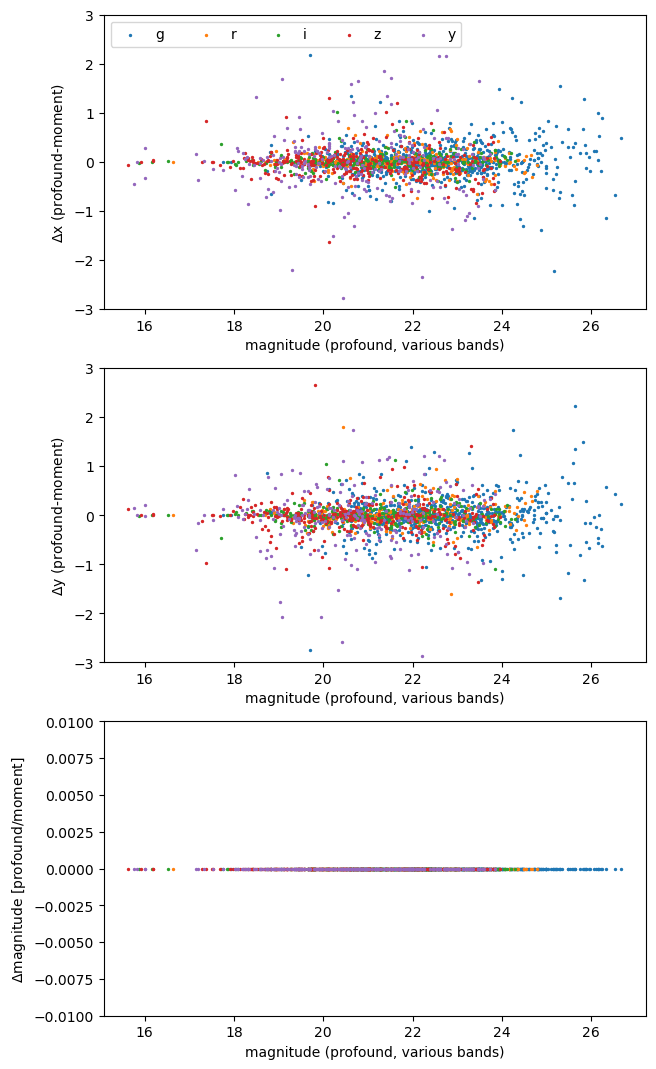

In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import pymysql
import morph
import mymysql
import os, sys, time

scratch_path = os.environ['MYSCRATCH']

import matplotlib.pyplot as plt
from matplotlib import cm

universe='IllustrisTNG'
simulation='TNG50-1'
database = 'IllustrisTNG50_1'
table = 'Morphologies_ProFit_HSC_Sersic'
snapnum=72

virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic' #/{snapnum:03}'

df = pd.read_csv('tmp.csv')

fig,axarr = plt.subplots(3,1,figsize=(7,13))

for band in ['g','r','i','z','y']:
    
    df_tmp = df.loc[df['band']==band]
    
    ax = axarr[0]
    y = df_tmp['profound0_xcen'] - df_tmp['moment_xcen']
    x = 22.5-2.5*np.log10(df_tmp['profound0_flux'])
    ax.scatter(x,y,s=2,label=band)
    ax.set_xlabel('magnitude (profound, various bands)')
    ax.set_ylabel(f'$\Delta$x (profound-moment)')
    ax.set_ylim(-3,3)
    
    ax = axarr[1]
    y = df_tmp['profound0_ycen'] - df_tmp['moment_ycen']
    x = 22.5-2.5*np.log10(df_tmp['profound0_flux'])
    ax.scatter(x,y,s=2)
    ax.set_xlabel('magnitude (profound, various bands)')
    ax.set_ylabel(f'$\Delta$y (profound-moment)')
    ax.set_ylim(-3,3)

    ax = axarr[2]
    y = -2.5*np.log(df_tmp['profound0_flux']/df_tmp['moment_flux'])
    x = 22.5-2.5*np.log10(df_tmp['profound0_flux'])
    ax.scatter(x,y,s=2)
    ax.set_xlabel('magnitude (profound, various bands)')
    ax.set_ylabel(f'$\Delta$magnitude [profound/moment]')
    ax.set_ylim(-0.01,0.01)

ax=axarr[0]
ax.legend(frameon=True,ncol=5,loc=2)

fig.savefig('profound_moments.jpg',dpi=256,bbox_inches='tight')


/tmp/ipykernel_3976833/3374134454.py:33: RuntimeWarning: invalid value encountered in log10
  22.5-2.5*np.log10(data/0.167**2),


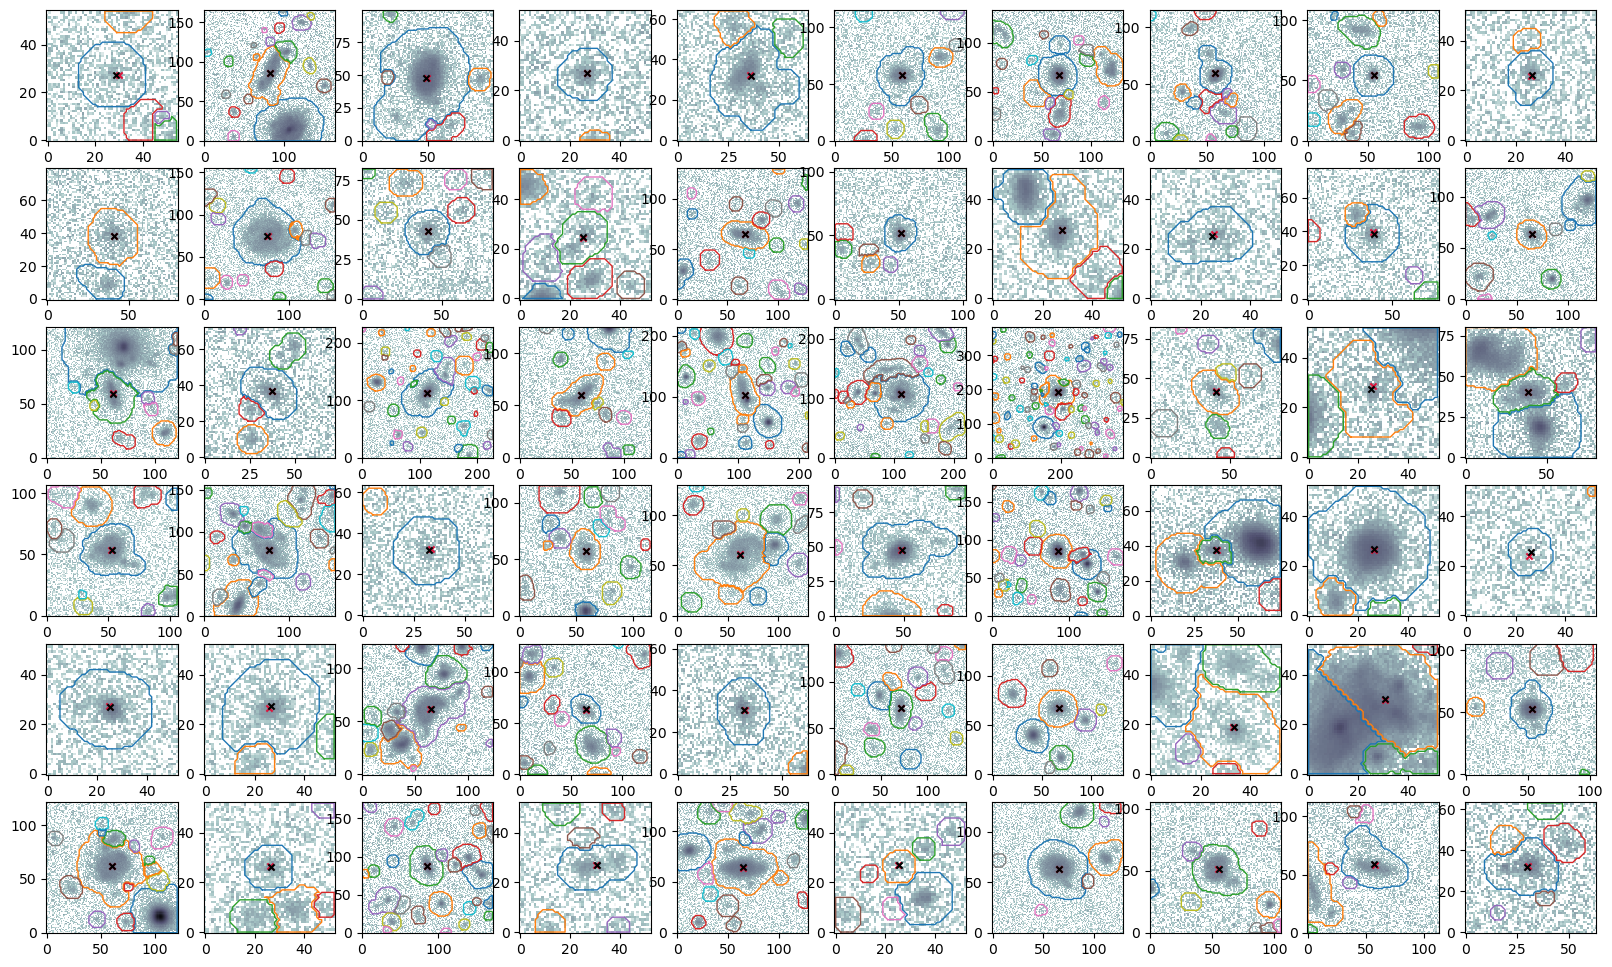

In [2]:
nrows=6
ncols=10
panelsize=2

fig,axarr=plt.subplots(nrows,ncols,figsize=(ncols*panelsize,nrows*panelsize))
axarr = axarr.flatten()

df_tmp = df.loc[df['band']=='g']
df_tmp.reset_index(inplace=True, drop=True)
nrecords = len(df_tmp)

np.random.seed(666)
idxs = np.random.choice(np.arange(nrecords,dtype=int),nrows*ncols,replace=False)

for ax,idx in zip(axarr,idxs):

    rec = df_tmp.loc[idx]
    snapnum = rec['snapnum']
    subfindid = rec['subfindid']
    camera = rec['camera']
    band = rec['band']

    img_name = f'{img_path}/{snapnum:03}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
    hdul = fits.open(img_name, mode='readonly')
    out_name = f'{img_path}/{snapnum:03}/profuse_{snapnum:03}-{subfindid}_{camera}_{band}.fits'
    result = fits.open(out_name, mode='readonly')

    segim = result['segim'].data
    segid = result['segid'].data[0]
    data = hdul[f'SUBARU_HSC.{band}'].data

    ax.imshow(
        22.5-2.5*np.log10(data/0.167**2),
        origin='lower',cmap='bone',vmin=18,vmax=30, 
        interpolation='None',aspect='equal'
    )

    xcen = rec['moment_xcen']
    ycen = rec['moment_ycen']

    morph.plot_segim_contours(ax,segim)

    buffer = 5
    ax.scatter(rec['profound_xcen'],rec['profound_ycen'],c='k',s=20,marker='x',zorder=1)
    ax.scatter(xcen,ycen,c='crimson',s=20,marker='x',zorder=0)
    # ax.set_xlim(xcen-buffer,xcen+buffer)
    # ax.set_ylim(ycen-buffer,ycen+buffer)

fig.savefig('profound_moments_images.jpg',dpi=256)

    






In [14]:
# Remove corrupt images (bad downloads)

import mymysql
import numpy as np
import os, sys

api_key = os.environ['TNG_API_KEY']
scratch_path = os.environ['MYSCRATCH']

universe='IllustrisTNG'
simulation='TNG50-1'
database = 'IllustrisTNG50_1'
table = 'Morphologies_ProFit_HSC_Sersic'
cnf_path='~/.mysql/ningaloo.cnf'

# Set up paths to image directories
virgotng_path = f'{scratch_path}/Simulations/virgotng'
sim_path = f'{virgotng_path}/data/{universe}/{simulation}'
img_path = f'{sim_path}/postprocessing/skirt_images_hsc/realistic'

dbcmd = f'SELECT snapnum,subfindid,camera from {table} where processflag!=0'
df = mymysql.query_df(dbcmd,database=database, cnf_path=cnf_path)

count = 0
for idx,row in df.iterrows():
    
    snapnum = row['snapnum']
    subfindid = row['subfindid']
    camera = row['camera']

    img_name = f'{img_path}/{snapnum:03}/shalo_{snapnum:03}-{subfindid}_{camera}_HSC_GRIZY.fits'
    if os.access(img_name,0): 
        os.remove(img_name)

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


In [16]:
    
    print('ProFound xcen',record['ProFound_xcen'])
    print('ProFound ycen',record['ProFound_ycen'])
    print('ProFound ang',record['ProFound_ang'])
    print('ProFound axrat',record['ProFound_axrat'])
    print('ProFound R100',record['ProFound_R100'])

    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse
    import petrofit as pf

    xcen = record['ProFound_xcen']
    ycen = record['ProFound_ycen']
    semimaj = record['ProFound_R100']
    axrat = record['ProFound_axrat']
    ang = record['ProFound_ang']

    fig,ax = plt.subplots(figsize=(5,5))
    ax.imshow(
        22.5-2.5*np.log10(img/0.167**2), origin='lower',
        interpolation='None',vmin=18,vmax=30,cmap='bone'
    )
    e = Ellipse(
        xy=[xcen,ycen],
        width=semimaj*axrat, height=semimaj,
        edgecolor='red',facecolor='None',alpha=1., 
        angle=ang,transform=ax.transData
    )
    ax.add_artist(e)

    fig,ax = plt.subplots(figsize=(5,5))
    ax.imshow(
        22.5-2.5*np.log10(img/0.167**2), origin='lower',
        interpolation='None',vmin=18,vmax=30,cmap='bone'
    )
    e = Ellipse(
        xy=[xcen,ycen],
        width=semimaj*axrat, height=semimaj,
        edgecolor='red',facecolor='None',alpha=1., 
        angle=ang,transform=ax.transData
    )
    ax.add_artist(e)

    masked_data = np.ones_like(img)*img
    masked_data[segim_secondary] = np.nan
    masked_stderr = np.ones_like(var)*np.sqrt(var)
    masked_stderr[segim_secondary] = np.nan
    skySigma = np.nanstd(img[segim==0])

    r_max = np.sqrt(img.shape[0]*img.shape[1])/np.sqrt(2)
    n_samples = min(int(2*r_max),100)
    r_list = pf.make_radius_list(max_pix=r_max, n=n_samples,log=True)

    flux_arr, area_arr, error_arr = pf.photometry.radial_photometry(
        masked_data, (xcen, ycen), r_list, error=masked_stderr, 
        mask=~segim_secondary, elong=1./axrat, theta=ang*np.pi/180+np.pi/2,
        plot=True, vmin=-3*skySigma, vmax=3*skySigma, method='exact')

    petro = pf.Petrosian(
        r_list, area_arr, flux_arr, flux_err=error_arr)

    print(petro.r_petrosian)
    


SyntaxError: unterminated string literal (detected at line 23) (2515172007.py, line 23)

In [26]:
24117*5*4*64/8/1e6

3.85872